In [1]:
import tensorflow as tf
import numpy as np

In [2]:
tf.random.set_seed(1234)
np.random.seed(1234)

## Loading MNIST Data

In [3]:
# Loading Data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# Adding Channel Lenght: Expanding from (28x28) to (28x28x1)
x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)
# Creating validation Subset
x_valid = x_train[50000:]  
y_valid = y_train[50000:]  

x_train = x_train[:50000]
y_train = y_train[:50000]


## Creating Dataset Objects

In [4]:
#Training
# ------------------------------
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0])

# Normalize images
def normalize_img(x_, y_):
    return tf.cast(x_, tf.float32) / 255., y_

# 1-hot encoding <- for categorical cross entropy
def to_categorical(x_, y_):
    return x_, tf.one_hot(y_, depth=10)

train_dataset = train_dataset.map(to_categorical)
train_dataset = train_dataset.map(normalize_img)

# Divide in batches
bs = 32
train_dataset = train_dataset.batch(bs)
# Repeat
# Without calling the repeat function the dataset 
# will be empty after consuming all the images
train_dataset = train_dataset.repeat()

In [5]:
#Validation   
# -----------------------
valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
# Normalize images
valid_dataset = valid_dataset.map(normalize_img)
# Enconding
valid_dataset = valid_dataset.map(to_categorical)
# Divide in batches
valid_dataset = valid_dataset.batch(bs)
# Repeat
valid_dataset = valid_dataset.repeat()

In [6]:
#Testing 
# -------------------
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(normalize_img)
test_dataset = test_dataset.map(to_categorical)
test_dataset = test_dataset.batch(1)

## Creating the model

In [7]:
# Implementation of the original Lenet5 
lenet = tf.keras.Sequential()
lenet.add(tf.keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='tanh', input_shape=(28,28,1), padding='same'))
lenet.add(tf.keras.layers.AveragePooling2D())
lenet.add(tf.keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='tanh', padding='valid'))
lenet.add(tf.keras.layers.AveragePooling2D())
lenet.add(tf.keras.layers.Flatten())
lenet.add(tf.keras.layers.Dense(units=120, activation='tanh'))
lenet.add(tf.keras.layers.Dense(units=84, activation='tanh'))
lenet.add(tf.keras.layers.Dense(units=10, activation = 'softmax'))

## Loading Pretrained Weights

In [8]:
# Loading Wieghts
#lenet.load_weights(checkpoint_path)

# Visualize Lenet 5 Architecture
lenet.summary()

# Visualize initialized weights
#lenet.weights

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

## Training Options

In [9]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
lenet.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Checkpoints

In [10]:
import os
from datetime import datetime

# Save Directory (Change for your own directory)
cwd = 'C:/Users/nicol/Desktop/Keras Testing' 

# Creating SubDirectory
exps_dir = os.path.join(cwd, 'Lenet5')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

exp_name = "Lenet5"

exp_dir = os.path.join(exps_dir, exp_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# ----------------

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1,write_graph=True,write_images=True,embeddings_freq=1)  
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    callbacks.append(es_callback)

# ---------------------------------

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR c--port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

## Training

In [11]:
lenet.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=int(np.ceil(x_train.shape[0] / bs)),
          validation_data=valid_dataset,
          validation_steps=int(np.ceil(x_valid.shape[0] / bs)), 
          callbacks=callbacks)

Train for 1563 steps, validate for 313 steps
Epoch 1/100
1563/1563 [==============================] - 13s 8ms/step - loss: 0.5310 - accuracy: 0.8049 - val_loss: 0.4116 - val_accuracy: 0.8516
Epoch 2/100
1563/1563 [==============================] - 11s 7ms/step - loss: 0.3818 - accuracy: 0.8589 - val_loss: 0.3828 - val_accuracy: 0.8556
Epoch 3/100
1563/1563 [==============================] - 11s 7ms/step - loss: 0.3402 - accuracy: 0.8739 - val_loss: 0.3370 - val_accuracy: 0.8778
Epoch 4/100
1563/1563 [==============================] - 11s 7ms/step - loss: 0.3112 - accuracy: 0.8832 - val_loss: 0.3254 - val_accuracy: 0.8765
Epoch 5/100
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2916 - accuracy: 0.8918 - val_loss: 0.3080 - val_accuracy: 0.8864
Epoch 6/100
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2706 - accuracy: 0.8993 - val_loss: 0.3192 - val_accuracy: 0.8825
Epoch 7/100
1563/1563 [==============================] - 11s 7ms/step - loss: 0

## Saving Weights

In [12]:
lenet.save_weights("C:/Users/nicol/Desktop/weights/Weights" )

## Checking the model predictions

In [13]:
import time
import matplotlib.pyplot as plt

In [14]:
# Iterator over test Dataset
iterator  = iter(test_dataset)

In [20]:
# Getting new image from iterator
image     = next(iterator)
image_plt = image[0][0,...,0]

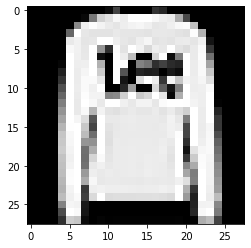

In [21]:
# Plotting Test image
plt.imshow(image_plt, cmap='gray')

In [27]:
# Target
tf.print("Target:",np.argmax(image[1]))
# Predicted Output
print("Prediction:",np.argmax(lenet.predict(image[0])))

Target: 2
Prediction: 2


#### Classes

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot